In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [2]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
from surprise import KNNWithMeans, SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from seaborn import violinplot

from scrap_data.data_import import load_data
from model.BaseRecommender import BaseRecommender
from model.UCSRecommender import UCSRecommender
from model.CFRecommender import CFRecommender
from model.CBRecommender import CBRecommender
from model.Recommender import Recommender

In [3]:
# import data
df_user, df_movie = load_data()

Data cleaning

In [4]:

df_movie = df_movie[df_movie["Avg_rating"] <= 10]

concat = lambda df, col1, col2: df[col1].astype(str) + "_" + df[col2].astype(str)

df_movie["Title"] = concat(df_movie, "Title", "Year")
df_user["Title"] = concat(df_user, "Title", "Year")
df_user = df_user.drop(columns="Year")

Feature engineering

In [5]:
# percentage difference between user rating and average rating (user-avg)

df_user_temp = df_user.merge(
    df_movie.groupby(["Title"])["Avg_rating"].max().reset_index(),
    on=["Title"],
    how="left",
)

df_user["Avg_user_rating_diff"] = df_user_temp["Rating"] - df_user_temp["Avg_rating"]

df_user = df_user.dropna()

In [6]:
# Mapping users to numbers
user_dict = {user: i for i, user in enumerate(df_user.User.unique())}
movie_dict = {title: i for i, title in enumerate(df_movie.Title.unique())}

df_user[["User", "Title"]] = df_user[["User", "Title"]].agg(
    {"User": lambda x: user_dict[x], "Title": lambda x: movie_dict[x]}
)
df_movie[["Title"]] = df_movie[["Title"]].agg({"Title": lambda x: movie_dict[x]})

In [7]:
# TODO: change that to get only subset of the movies.

val_user_list = [user_dict[it] for it in ["sokoly35", "honorciak", "piotrr99"]]
df_user_validation = df_user[df_user["User"].isin(val_user_list)]

# exclude us from df_user
df_user = df_user[~df_user.index.isin(df_user_validation.index)]

<AxesSubplot: ylabel='Avg_user_rating_diff'>

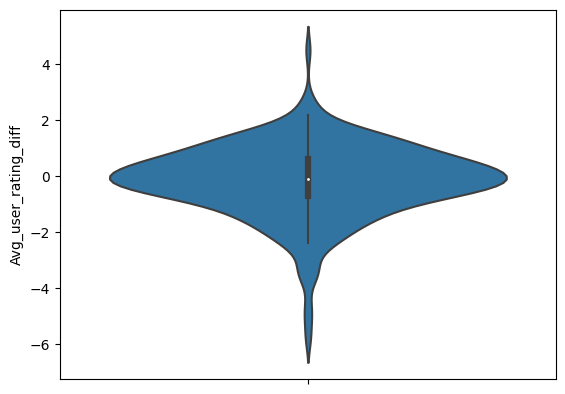

In [8]:
violinplot(df_user_validation, y = "Avg_user_rating_diff")


In [9]:
def decode(df, user_dict, movie_dict):
    # decode users and movies
    user_dict_decoder = {val: key for key, val in user_dict.items()}
    movie_dict_decoder = {val: key for key, val in movie_dict.items()}
    df_cols = df.columns
    if "User" in df_cols:
        df["User"] = df["User"].agg(lambda x: user_dict_decoder[x])
    if "Title" in df_cols:
        df["Title"] = df["Title"].agg(lambda x: movie_dict_decoder[x])
    return df

# 1. User cold start
* recommendation based on popularity and overall rating of the movie for users with not many rated movies
* we have no data about the user (age, gender, ...) so we don't use it as a feature in collaborative filtering.

In [10]:
# example of usage
ucs_recommender = UCSRecommender(df_movie)
ucs_recommender.train(df_user)
recommendations = ucs_recommender.predict(
    df_user=df_user_validation, num_of_recomendations=5
)
decode(recommendations, user_dict, movie_dict)

,User,Title,Rating
5744,honorciak,Skazani na Shawshank_1994,8.8
7433,honorciak,Zielona mila_1999,8.6
4163,honorciak,Nietykalni_2011,8.6
1867,honorciak,Forrest Gump_1994,8.5
5264,honorciak,Pulp Fiction_1994,8.3
5744,piotrr99,Skazani na Shawshank_1994,8.8
7433,piotrr99,Zielona mila_1999,8.6
4163,piotrr99,Nietykalni_2011,8.6
1867,piotrr99,Forrest Gump_1994,8.5
5264,piotrr99,Pulp Fiction_1994,8.3


# 2. Collaborative filtering
* user similarity

In [11]:
cf_recommender = CFRecommender(df_movie)
cf_recommender.train(pd.concat([df_user, df_user_validation]))
recommendations = cf_recommender.predict(df_user_validation, None)

decode(recommendations, user_dict, movie_dict)

,User,Title,Rating
1347,honorciak,Django_2012,8.494401
1535,honorciak,Dwunastu gniewnych ludzi_1957,8.451422
7178,honorciak,Władca Pierścieni: Powrót króla_2003,8.449907
2091,honorciak,Gran Torino_2008,8.423723
4162,honorciak,Nietykalni_2011,8.409994
...,...,...,...
2697,sokoly35,Kac Wawa_2011,5.011261
2841,sokoly35,Kobiety mafii_2018,4.845327
4815,sokoly35,Pięćdziesiąt twarzy Greya_2015,4.785608
6749,sokoly35,W lesie dziś nie zaśnie nikt_2020,4.740588


# 3. Content based
* movie similarity

In [12]:
cb_recommender = CBRecommender(df_movie)
recommendations = cb_recommender.predict(
    df_user=df_user_validation, num_of_recomendations=-1
)
decode(recommendations, user_dict, movie_dict)

,User,Title,Rating
0,honorciak,Zakochany bez pamięci_2004,5.721354
1,honorciak,Brazil_1985,5.650386
2,honorciak,Nie patrz w górę_2021,5.634398
3,honorciak,Człowiek z księżyca_1999,5.621758
4,honorciak,Gorączka_2021,5.558963
...,...,...,...
23197,sokoly35,Harry Potter i Książę Półkrwi_2009,0.000000
23198,sokoly35,Legion samobójców_2016,0.000000
23199,sokoly35,Gwiezdne wojny: Przebudzenie Mocy_2015,0.000000
23200,sokoly35,Avengers_2012,0.000000


# 4. Final model

In [19]:
recommender = Recommender(df_movie)
recommender.train(df_user)
recommendations = recommender.predict(
    df_user=df_user_validation, num_of_recomendations=-1
)
decode(recommendations, user_dict, movie_dict)


,User,Title,Rating
1867,honorciak,Palm Springs_2020,6.704642
5744,honorciak,Za pięć dwunasta_2007,6.690303
417,honorciak,Odrobina chaosu_2014,6.653304
3258,honorciak,Twarz_2017,6.617258
2006,honorciak,Fokstrot_2017,6.602114
...,...,...,...
6263,sokoly35,Dziewczyna ze zdjęcia_2022,0.235745
6448,sokoly35,Cisza_2010,0.228596
6466,sokoly35,Chwała dziwkom_2011,0.227967
7446,sokoly35,Głęboka woda_2022,0.166056


In [14]:
df_user_validation

,User,Title,Rating,Avg_user_rating_diff
9900,82,5744,9.0,0.2
9901,82,7433,10.0,1.4
9902,82,318,6.0,-0.5
9903,82,2148,3.0,-4.6
9904,82,1171,7.0,0.1
...,...,...,...,...
32486,261,6264,8.0,0.4
32487,261,2469,7.0,-0.6
32488,261,2409,7.0,-0.4
32489,261,7447,5.0,-2.2
